# PyBlock Demonstration

<hr>
<u>Author Information</u><br>
Timothy Lang<br>
NASA MSFC<br>
timothy.j.lang@nasa.gov<br>
<hr>

Welcome to the PyBlock demonstration notebook. PyBlock is a Python 2/3 module that enables the end user to estimate partial beam blockage using polarimetric radar data. The methodologies it uses depend on the self-consistency of polarimetric radar variables - reflectivity (Zh), differential reflectivity (Zdr), and specific differential phase (Kdp) - in pure rain. There are two methodologies currently available to the end user, both described in Lang et al. (2009): The KDP method, and the Fully Self-Consistent (FSC) method. Briefly, the KDP method will check the behavior of Zh and Zdr for a given range of Kdp both inside and outside of blocked azimuths, and use that to suggest corrections to these measurands. This is effectively a relative calibration of Z and Zdr. The FSC method uses a derived or specified self-consistency relationship to do an absolute calibration of Zh within the blocked regions.

PyBlock implements these methodologies within an object-oriented Python framework. Before getting started, however, you will need to install the following:
<ul>
<li>A robust version of Python 2.7 or 3.4-3.6 (other version untested) w/ most standard scientific packages (e.g., numpy, matplotlib, pandas, etc.) - Get one for free here: https://store.continuum.io/cshop/anaconda/</li>
<li>The Python Atmospheric Radiation Measurement (ARM) Radar Toolkit (Py-ART; https://github.com/ARM-DOE/pyart)</li>
<li>CSU_RadarTools (https://github.com/CSU-Radarmet/CSU_RadarTools)</li>
<li>SkewT (https://pypi.python.org/pypi/SkewT) - a Python 3 version can be found here: https://github.com/tjlang/SkewT</li>
<li>DualPol - a Python module by Timothy Lang (https://github.com/nasa/DualPol)</li>
</ul>

<i>Reference</i><br>
Lang, T. J., S. W. Nesbitt, and L. D. Carey, 2009: On the correction of partial beam blockage in polarimetric radar data. <i>J. Atmos. Oceanic Technol.</i>, <b>26</b>, 943–957.

In [1]:
from __future__ import print_function
from __future__ import division
import numpy as np
import matplotlib.pyplot as plt
import glob
import pyart
import pyblock
import dualpol
%matplotlib inline

/Users/tjlang/anaconda/envs/py3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


PyBlock relies heavily on DualPol, which itself relies heavily on Py-ART and CSU_RadarTools. Let's talk a bit about how this works. The purpose of DualPol is to perform common polarimetric retrievals (e.g., fuzzy-logic hydrometeor identification, blended rainfall rates, drop-size distribution parameters, etc.). Py-ART powers the ingest of radar volumes, the addition of newly created variables to the volumes, and the visualization of the results. Meanwhile, CSU_RadarTools does the actual retrievals. So what DualPol does is work as an object-oriented interface between these two modules. PyBlock needs these retrievals to obtain fuzzy HID categories so it can isolate pure rain for the blockage analyses. It also relies on them to obtain Kdp if it has not yet been calculated.

Before moving on to PyBlock, let's do a quick demo of DualPol so you understand how this process works. We are going to work with a small portion of the NPOL radar dataset from the Iowa Flood Studies (IFloodS) campaign. The volumes cover late in the day on 5/22/2013. 

<hr>

### Brief Intro to DualPol and Its Relevance to PyBlock

In [2]:
datadir = '/Volumes/Storage01/PyBlock/'
files = sorted(glob.glob(datadir+'np*'))
print('Number of files:', len(files))
test_volume = pyart.io.read(files[0])
print(test_volume.fields.keys())

Number of files: 44
dict_keys(['total_power', 'reflectivity', 'velocity', 'spectrum_width', 'differential_reflectivity', 'specific_differential_phase', 'cross_correlation_ratio', 'normalized_coherent_power', 'differential_phase'])


The volumes already have Kdp, but I believe these volumes are straight out of Sigmet/IRIS so the Kdp isn't that great. Plus there is no HID. So let's demonstrate how DualPol can help with all this.

In [3]:
help(dualpol.DualPolRetrieval)

Help on class DualPolRetrieval in module dualpol.dualpol:

class DualPolRetrieval(builtins.object)
 |  Class that wraps all the dual-polarization retrievals powered by
 |  CSU_RadarTools.
 |  
 |  Brief overview of DualPolRetrieval structure
 |  --------------------------------------------
 |  Main attributes of interest is radar, which is the original Py-ART radar
 |  object provided to DualPolRetrieval. DualPolRetrieval.radar contains
 |  new fields based on what the user wanted DualPolRetrieval to do.
 |  
 |  New fields that can be in DualPolRetrieval.radar.fields:
 |  'FH' (or whatever user provided in name_fhc kwarg) = HID
 |  'FI' = Ice Fraction
 |  'ZDP' = Difference Reflectivity
 |  'KDP_CSU' = KDP as calculated by CSU_RadarTools
 |  'FDP_CSU' = Filtered differential phase
 |  'SDP_CSU' = Standard deviation of differential phase
 |  'MI' = Mass of ice
 |  'MW' = Mass of liquid water
 |  'rain' = Rainfall rate
 |  'method' = Rainfall method used
 |  'D0' = Median Volume Diamete

In [4]:
sndfile = '/Volumes/Storage01/PyBlock/sounding_dvn_20130523_00z.txt'
rm = 'hidro'
retrieve = dualpol.DualPolRetrieval(
    files[0], dz='reflectivity', dr='differential_reflectivity', 
    rh='cross_correlation_ratio', dp='differential_phase', use_temp=True,
    band='S', fhc_method='hybrid', sounding=sndfile,
    ice_flag=False, rain_method=rm)
print(retrieve.radar.fields.keys())

0.22162914276123047 seconds to run csu_kdp
0.5131280422210693 seconds to do FHC
dict_keys(['total_power', 'reflectivity', 'velocity', 'spectrum_width', 'differential_reflectivity', 'specific_differential_phase', 'cross_correlation_ratio', 'normalized_coherent_power', 'differential_phase', 'FDP_CSU', 'SDP_CSU', 'KDP_CSU', 'temperature', 'FH', 'rain', 'method', 'D0', 'NW', 'MU', 'MW', 'MI'])


Lots of new fields created! The sounding file is from nearby Davenport. It is read in using SkewT, which expects the UWyo sounding format. If the Kdp field is not provided (kd keyword), DualPolRetrieval will try to calculate it, and that requires the user providing the differential phase field (dp keyword). Anyway, DualPolRetrieval takes about half a minute or so to run on my laptop. Now let's plot up some results. But first, define a function to simplify plotting up several fields at once using Py-ART.

In [5]:
def plot_list_of_fields(radar, sweep=0, fields=['reflectivity'], vmins=[0], vmaxs=[65],
                        units=['dBZ'], cmaps=['RdYlBu_r'], return_flag=False,
                        xlim=[-150,150], ylim=[-150,150]):
    num_fields = len(fields)
    nrows = (num_fields + 1) // 2
    ncols = (num_fields + 1) % 2 + 1
    fig = plt.figure(figsize=(12, float(nrows)*5))
    display = pyart.graph.RadarDisplay(radar)
    for index, field in enumerate(fields):
        ax = fig.add_subplot(nrows, 2, index+1)
        display.plot(field, sweep=sweep, vmin=vmins[index], vmax=vmaxs[index], 
                     colorbar_label=units[index], cmap=cmaps[index])
        display.set_limits(xlim=xlim, ylim=ylim)
    plt.tight_layout()
    if return_flag:
        return display

Conveniently, DualPol has an HidColors object that simplifies the colormaps for the HID field ('FH') and the blended rainfall method field ('method'). Let's use that and plot up some of the fields.

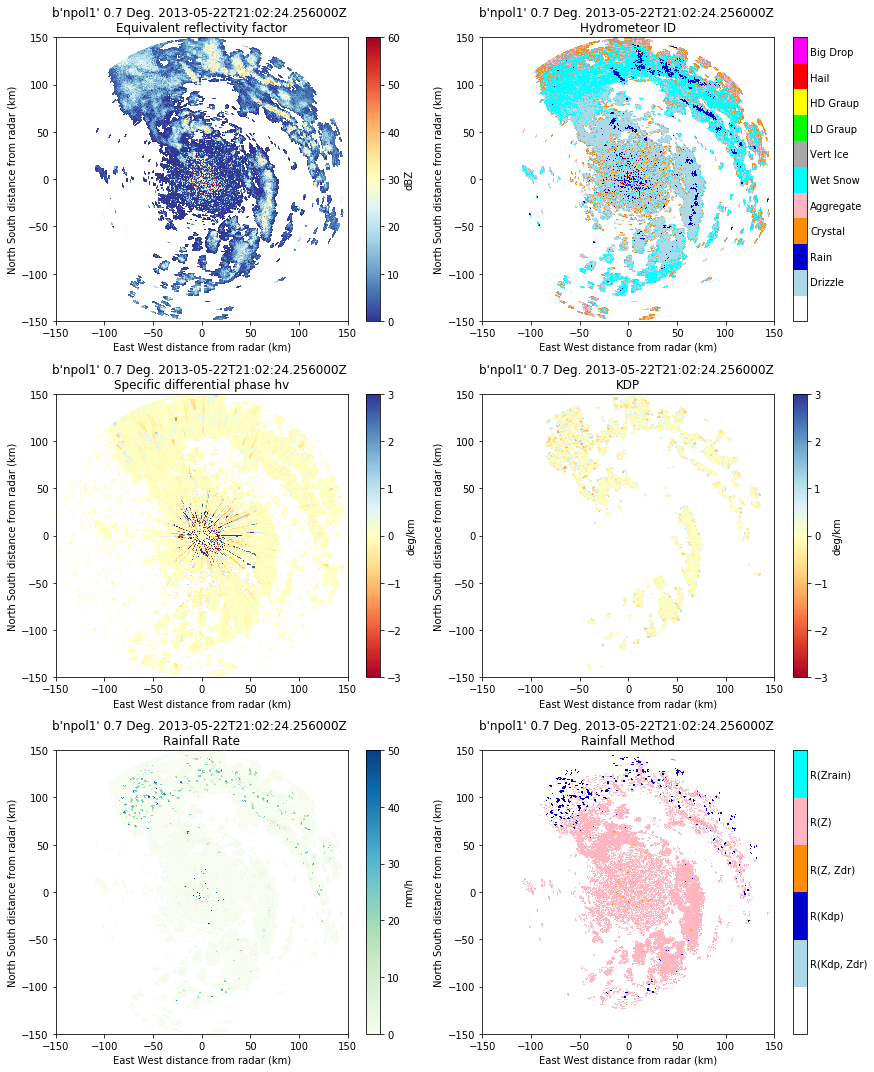

In [6]:
hidcolors = dualpol.HidColors()
display = plot_list_of_fields(
    retrieve.radar, fields=['reflectivity', 'FH', 'specific_differential_phase',
                            'KDP_CSU', 'rain', 'method'], return_flag=True,
    vmins=[0, 0, -3, -3, 0, 0], vmaxs=[60, 10, 3, 3, 50, 5], 
    units=['dBZ', '', 'deg/km', 'deg/km', 'mm/h', ''], 
    cmaps=['RdYlBu_r', hidcolors.cmaphid, 'RdYlBu', 'RdYlBu', 'GnBu', hidcolors.cmapmeth])
display.cbs[1] = hidcolors.adjust_fhc_colorbar_for_pyart(display.cbs[1])
display.cbs[5] = hidcolors.adjust_meth_colorbar_for_pyart(display.cbs[5])

Hmm ... a lot of QC issues it looks like. These are basically raw NPOL data so it's not surprising. In the middle row, the CSU_KDP field (right) is compared against the default Kdp (left). CSU_KDP is computed using a finite impulse response (FIR) filter on the differential phase field, and the standard deviation of the differential phase is used to eliminate most non-precipitating echoes.

At any rate, PyBlock will filter out a lot of specious echo and try to focus only on areas of actual rain and drizzle. So now that a brief intro to DualPol is done let's move on to running PyBlock.

<hr>

### PyBlock on a Single File

First up, let's just run this module on a single file. For real blockage analyses, we need hours if not days of widespread precipitation for best results, so the following is mainly for illustrative purposes.

In [7]:
single_bb = pyblock.BeamBlockSingleVolume(
    files[0], sweep=0, dz='reflectivity', dr='differential_reflectivity',
    rh='cross_correlation_ratio', dp='differential_phase',
    magnetron=True, vr='velocity', rain_kdp_thresh=[1, 1.5], 
    image_dir='/Volumes/Storage01/PyBlock/', debug=True)

debug radar keys dict_keys(['total_power', 'reflectivity', 'velocity', 'spectrum_width', 'differential_reflectivity', 'specific_differential_phase', 'cross_correlation_ratio', 'normalized_coherent_power', 'differential_phase'])
0.11652994155883789 seconds to run csu_kdp
0.28453707695007324 seconds to do FHC


The BeamBlockSingleVolume object is PyBlock's way of interfacing with individual radar volumes, isolating rain/drizzle echoes,  and binning up data from each azimuth. Let's see what it contains ...

In [8]:
help(single_bb)

Help on BeamBlockSingleVolume in module pyblock.pyblock object:

class BeamBlockSingleVolume(builtins.object)
 |  Core class that processes single volume of radar data and isolates all the
 |  individual gates that meet the user-specified criteria for rain (used for
 |  determining reflectivity blockage via KDP method) as well as for drizzle
 |  (used for determining differential reflectivity blockage for both the KDP
 |  and FSC methods). An additional mask is applied to obtain good rain/drizzle
 |  data for the FSC method.
 |  
 |  Many kwargs are passed to dualpol.DualPolRetrieval, which is used to
 |  calculate KDP (if necessary) and also do hydrometeor identification.
 |  
 |  Py-ART is used to ingest the individual radar files. The csu_radartools
 |  module is used to help filter bad data like insects.
 |  
 |  Methods defined here:
 |  
 |  __init__(self, filename, **kwargs)
 |      Must specify names of key polarimetric radar fields.
 |      KDP is optional - will calculate if 

In [9]:
dir(single_bb)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 'azimuth',
 'azimuth_indices',
 'bad_data_mask',
 'bin_width',
 'debug',
 'dp',
 'dr',
 'dr_mask',
 'drizz_total_pts',
 'drizzle_binned_dr',
 'drizzle_good_mask',
 'drizzle_not_dz',
 'drizzle_not_fhc',
 'drizzle_not_kdp',
 'dz',
 'dz_mask',
 'fhc',
 'fix_rng_thresh',
 'fsc_binned_data',
 'fsc_good_mask',
 'fsc_not_fhc',
 'get_2d_azimuth_and_range',
 'get_bad_data_mask',
 'get_bins',
 'get_range_mask',
 'group_drizzle_data',
 'group_fsc_data',
 'group_rain_data',
 'insect_mask',
 'kd',
 'kd_mask',
 'main_loop',
 'maxZ',
 'nbins',
 'partition_drizzle_data',
 'partition_fsc_data',
 'partition_rain_data',
 'radar',
 'rain_bin

Basically, once Kdp and HID are obtained, polarimetric data are filtered using a long series of masks. Rain echoes are kept track of (via the rain_binned_dz attribute) to enable later Zh corrections via the KDP methods, and the same is done with drizzle echoes (via the drizzle_binned_dr attribute) to power the Zdr corrections. Meanwhile, data for later FSC analysis is kept in the fsc_binned_data attribute.

As we can see above, this volume didn't have much rain, so as an example let's look at the drizzle data. The drizzle_binned_dr attribute is basically a list of the Zdr values from gates meeting the drizzle criteria (default: good data w/ HID=1 and Kdp between -0.1 and +0.1 deg/km).

In [10]:
# Its shape is the number of azimuth bins (set by bin_width, which defaults to 1 deg)
print(np.shape(single_bb.drizzle_binned_dr))

(360,)


In [11]:
# At each azimuth, there is a variable-length list of Zdr values.
# Sometimes there will be a lot ...
print(single_bb.drizzle_binned_dr[170])

[-0.2         0.23999999 -0.08       -0.81        0.27000001  0.31999999
  0.31999999  0.25999999 -0.69        0.28       -0.2         0.19
  0.91000003  0.40000001  0.06       -0.08        0.15000001  0.23       -0.01
  0.22        0.31999999  0.2        -0.23       -0.07       -0.01
 -0.15000001 -0.06        0.22        0.22        0.25        0.68000001
  0.87        0.67000002  0.41        0.46000001 -0.27000001  0.03
  0.85000002 -0.17        0.20999999  0.20999999 -0.25999999 -0.07
  0.58999997  0.91000003  0.03        0.02        0.23        0.44999999
  0.30000001 -0.15000001 -0.25999999  0.67000002  0.04        0.03        0.62
  0.37        0.79000002  0.06        0.05       -0.14        0.25999999
 -0.17        0.91000003  0.50999999  0.03       -0.92000002  0.31        0.37
  0.88999999 -0.17       -0.73000002 -1.12        0.52999997]


In [12]:
# And sometimes there will just be an empty list with no data
print(single_bb.drizzle_binned_dr[2])

[]


In [13]:
# The actual azimuth you are examining at each index is simply
print('index = 2 corresponds to', 2 * single_bb.bin_width, 'degrees Azimuth')
print('index = 170 corresponds to', 170 * single_bb.bin_width, 'degrees Azimuth')

index = 2 corresponds to 2.0 degrees Azimuth
index = 170 corresponds to 170.0 degrees Azimuth


The same basic idea holds for fsc_binned_data, except that starts out as a dictionary with Zh ('DZ'), Zdr ('DR'), and Kdp ('KD') being individual keys that each hold separate lists of lists. For FSC, there are more data allowed as while we still limit to rain/drizzle, we don't threshold on Kdp range at all. So that data dictionary will be much bigger as far more data per azimuth are used in the FSC method.

In [14]:
print(single_bb.fsc_binned_data.keys())

dict_keys(['DZ', 'DR', 'KD'])


In [15]:
print(single_bb.fsc_binned_data['DZ'][170])

[ 15.31999969  15.60000038  10.61999989  16.46999931  19.80999947
  22.19000053  27.84000015  27.40999985  30.55999947  16.55999947
  26.06999969  29.23999977  33.47999954  27.71999931  25.75        20.38999939
  26.18000031  27.35000038  19.56999969  24.34000015  21.20999908
  21.88999939  15.85000038  19.63999939  17.80999947  20.14999962
  18.90999985  16.54999924  17.55999947  12.13000011  13.10000038
   3.9000001   15.68000031  17.12999916  18.26000023  18.65999985
  13.64999962  15.22999954  19.67000008  11.14999962  19.31999969
  18.65999985  20.65999985  17.79999924  16.88999939  21.51000023
  18.47999954  15.03999996  17.45000076  17.88999939  16.20000076
  15.96000004  13.07999992  12.19999981  14.14999962  16.46999931
  18.11000061  10.48999977  13.65999985  16.81999969  18.34000015  17.25
   9.39999962  17.52000046  26.19000053  17.95000076  17.37000084
  17.29000092  19.93000031  20.64999962  18.5         20.85000038
  17.04000092  13.93999958  10.21000004  10.07999992  19

How do we go from analyzing a single file to grouping together data from a host of files? That is the subject of the next section, but first here are all the possible kwargs you can send to BeamBlockSingleVolume. Many of these are passed along to DualPol, and most have some sort of non-None default value to help you get your intitial analayses up and running.

In [16]:
print(pyblock.DEFAULT_KW)

{'sweep': 0, 'dz': 'ZH', 'dr': 'DR', 'dp': 'DP', 'rh': 'RH', 'kd': None, 'ld': None, 'sounding': '/Users/tjlang/anaconda/envs/py3/lib/python3.6/site-packages/pyblock-1.4-py3.6.egg/pyblock/data/default_sounding.txt', 'verbose': False, 'thresh_sdp': 12, 'fhc_T_factor': 1, 'fhc_weights': {'DZ': 1.5, 'DR': 0.8, 'KD': 1.0, 'RH': 0.8, 'LD': 0.5, 'T': 0.4}, 'fhc_name': 'FH', 'band': 'S', 'fhc_method': 'hybrid', 'kdp_method': 'CSU', 'bad': -32768, 'use_temp': True, 'rain_dp_thresh': 100, 'drizzle_dz_thresh': 25, 'vr': 'VR', 'magnetron': False, 'bin_width': 1.0, 'rain_kdp_thresh': [1.5, 2], 'drizzle_kdp_thresh': [-0.1, 0.1], 'rng_thresh': [20, 90], 'dsd_flag': False, 'output': 100, 'rain_dz_thresh': 39, 'liquid_ice_flag': False, 'precip_flag': False, 'maxZ': 55, 'debug': False, 'gzip': True}


In [17]:
# Below is a docstring from the PyBlock code describing most of these kwargs
"""
kwargs descriptions
-------------------
sweep = Sweep number to examine
dz = Name of reflectivity field in Py-ART radar object
dr = Name of differential reflectivity field in Py-ART radar object
dp = Name of differential phase field in Py-ART radar object
rh = Name of correlation coefficient field in Py-ART radar object
kd = Name of specific differential phase field in Py-ART radar object (if avail.)
ld = Name of linear depolarization ratio field in Py-ART radar object (if avail.)
vr = Name of Doppler velocity field in Py-ART radar object
verbose = Set to True for text notifications
thresh_sdp = Threshold for specific differential phase (can vary spatially)
fhc_T_factor = Extra weighting to be used for T in FHC calculations
fhc_weights = Weights used for each polarimetric and T field in FHC calculations
fhc_name = Name to give to newly created FHC field
band = Wavelength band of radar ('S' or 'C' supported)
fhc_method = Method to use in FHC calculations
kdp_method = Method to use in KDP calculations
bad = Bad data value
use_temp = Set to False to not use T in FHC
rain_dp_thresh = Differential phase threshold below which data will not be used
                 in KDP-method blockage calculation unless reflectivity exceeds
                 rain_dz_thresh
drizzle_dz_thresh = Reflectivity threshold above which data will not be used in
                    determination of ZDR blockage magnitude
magnetron = Set to True if transmitter was a magnetron and you can thus remove
            second-trip by filtering on Doppler velocity
bin_width = Width of each bin in azimuth degrees for determining blockage
rain_kdp_thresh = Two-element tuple denoting min/max KDP values to consider in
                  estimation of reflectivity blockage via KDP method
drizzle_kdp_thresh = Two-element tuple denoting min/max KDP values to consider in
                     estimation of ZDR blockage
rng_thresh = Two-element tuple or list of tuples (same size as number of bins in
             blockage calculation) indicating range (km) to consider for analysis
             of blockage
dsd_flag = Set to True to also retrieve DSD parameters via DualPol
output = Number of files to process at a time before outputting raw data for 
         analysis
rain_dz_thresh = Reflectivity threshold below which data will not be used
                 in KDP-method blockage calculation unless differential phase
                 exceeds rain_dp_thresh
liquid_ice_flag = Set to True to also retrieve liquid/ice mass via DualPol
precip_flag = Set to True to also retrieve rainfall rate via DualPol
maxZ = Integer, highest Z value to consider in FSC method (to avoid ice contam.)
debug = Set to True to check the BeamBlockSingleVolume processing loop
gzip = Set to True to keep temporary block data HDF5 file gzipped
"""
print()

<hr>

### PyBlock on Multiple Files

The next main PyBlock object is BeamBlockMultiVolume. This is actually a child of another PyBlock object called BlockStats, from which it inherits methods for collating, reading, and writing multi-volume blockage statistics. It is invoked very similarly to BeamBlockSingleVolume. That is because it basically iteratively calls BeamBlockSingleVolume for each radar volume, and then collates and stores the data.

In [18]:
multi_bb = pyblock.BeamBlockMultiVolume(
    files,  # save='./temporary_block_data.dat',
    dz='reflectivity', dr='differential_reflectivity',
    rh='cross_correlation_ratio', dp='differential_phase',
    magnetron=True, vr='velocity', rain_dp_thresh=50, ld=None,
    rain_kdp_thresh=[1, 1.5], 
    image_dir='/Volumes/Storage01/PyBlock/')

i= 0 of 43
radar file: np1130522210213.RAWGMX8 & sounding: default_sounding.txt
0.11714005470275879 seconds to run csu_kdp
0.296032190322876 seconds to do FHC
Total KDP method points - rain, drizzle: 0 6151
Saving statistics to file and plotting an image

i= 1 of 43
radar file: np1130522210443.RAWGMXL & sounding: default_sounding.txt
0.11672401428222656 seconds to run csu_kdp
0.2879459857940674 seconds to do FHC
Total KDP method points - rain, drizzle: 5 12372

i= 2 of 43
radar file: np1130522210711.RAWGMXZ & sounding: default_sounding.txt
0.11921906471252441 seconds to run csu_kdp
0.30933403968811035 seconds to do FHC
Total KDP method points - rain, drizzle: 11 18603

i= 3 of 43
radar file: np1130522210954.RAWGMYB & sounding: default_sounding.txt
0.11377692222595215 seconds to run csu_kdp
0.2990739345550537 seconds to do FHC
Total KDP method points - rain, drizzle: 12 25147

i= 4 of 43
radar file: np1130522211238.RAWGMYP & sounding: default_sounding.txt
0.12214398384094238 seconds to 

/Users/tjlang/anaconda/envs/py3/lib/python3.6/site-packages/pyblock-1.4-py3.6.egg/pyblock/pyblock.py:324: RuntimeWarning: invalid value encountered in less
  self.rain_not_kdp = np.logical_or(self.kd < rain_kdp_thresh[0],
/Users/tjlang/anaconda/envs/py3/lib/python3.6/site-packages/pyblock-1.4-py3.6.egg/pyblock/pyblock.py:325: RuntimeWarning: invalid value encountered in greater
  self.kd > rain_kdp_thresh[1])
/Users/tjlang/anaconda/envs/py3/lib/python3.6/site-packages/pyblock-1.4-py3.6.egg/pyblock/pyblock.py:335: RuntimeWarning: invalid value encountered in less
  self.drizzle_not_kdp = np.logical_or(self.kd < drizzle_kdp_thresh[0],
/Users/tjlang/anaconda/envs/py3/lib/python3.6/site-packages/pyblock-1.4-py3.6.egg/pyblock/pyblock.py:336: RuntimeWarning: invalid value encountered in greater
  self.kd > drizzle_kdp_thresh[1])
/Users/tjlang/anaconda/envs/py3/lib/python3.6/site-packages/pyblock-1.4-py3.6.egg/pyblock/pyblock.py:347: RuntimeWarning: invalid value encountered in greater
  self

0.13437104225158691 seconds to run csu_kdp
0.31270408630371094 seconds to do FHC
Total KDP method points - rain, drizzle: 136 178279

i= 30 of 43
radar file: np1130522222140.RAWGN7Z & sounding: default_sounding.txt
0.1173710823059082 seconds to run csu_kdp
0.3195521831512451 seconds to do FHC
Total KDP method points - rain, drizzle: 138 183278
Saving statistics to file and plotting an image

i= 31 of 43
radar file: np1130522222430.RAWGN8B & sounding: default_sounding.txt
0.12217926979064941 seconds to run csu_kdp
0.2942960262298584 seconds to do FHC
Total KDP method points - rain, drizzle: 139 188618

i= 32 of 43
radar file: np1130522222718.RAWGN8P & sounding: default_sounding.txt
0.13166522979736328 seconds to run csu_kdp
0.3204340934753418 seconds to do FHC
Total KDP method points - rain, drizzle: 139 193571

i= 33 of 43
radar file: np1130522223007.RAWGN92 & sounding: default_sounding.txt
0.1236562728881836 seconds to run csu_kdp
0.2990860939025879 seconds to do FHC
Total KDP method 

The purpose of BeamBlockMultiVolume is to combine the blockage-relevant data from however many volumes the user wants to analyze. Periodically, statistics are saved to file and a plot is made. In addition, there can be periodic output of all the collated data to an HDF5  file via the h5py module. This enables the user to start collating from a new set of data without losing the old data. You simply point to the old savefile via the save keyword and all those individual gates will get loaded back up for further appending. This save/load characteristic is managed by PyBlock's RawDataStorage object.

In [19]:
# Let's get the docstings on all three of these objects.
help(pyblock.BlockStats)

Help on class BlockStats in module pyblock.pyblock:

class BlockStats(builtins.object)
 |  Helper class that enables ingest and plotting of blockage statistics.
 |  
 |  Methods defined here:
 |  
 |  __init__(self)
 |      Purpose of this class is to provide useful common methods to other
 |      classes. Hence, there is no point to populate __init__().
 |  
 |  load_stats(self, filename)
 |      Load KDP-method azimuth-based blockage stats from file.
 |  
 |  make_plots(self)
 |      Makes a two-panel plot of reflectivity and differential reflectivity
 |      blockage as functions of azimuth.
 |  
 |  ----------------------------------------------------------------------
 |  Data descriptors defined here:
 |  
 |  __dict__
 |      dictionary for instance variables (if defined)
 |  
 |  __weakref__
 |      list of weak references to the object (if defined)



In [20]:
help(pyblock.BeamBlockMultiVolume)

Help on class BeamBlockMultiVolume in module pyblock.pyblock:

class BeamBlockMultiVolume(BlockStats)
 |  This class facilitates the ingest of multiple radar volumes to compute beam
 |  blockage as functions of individual variables (Z, ZDR) and azimuth.
 |  
 |  Key Attributes
 |  --------------
 |  rain_refl - Reflectivity data meeting rain criteria implemented by
 |              BeamBlockSingleVolume, as a function of azimuth.
 |  drizz_zdr - Differential reflectivity data meeting drizzle criteria
 |              implemented by BeamBlockSingleVolume, as a function of azimuth.
 |  fsc_data - Dict containing reflectivity, differential reflectivity, and
 |             specific differential phase data for use with the FSC method.
 |             Keys are 'DZ', 'DR', and 'KD' and data are arranged by azimuth.
 |  Azimuth - Array of azimuth bins.
 |  rain_stats - Dict of rain statistics as functions of azimuth (KDP method).
 |  drizzle_stats - Same but for drizzle statistics (KDP/FSC method

In [21]:
help(pyblock.RawDataStorage)

Help on class RawDataStorage in module pyblock.pyblock:

class RawDataStorage(builtins.object)
 |  Class that facilitates saving and loading of azimuth-binned reflectivity
 |  and differential reflectivity data. Uses h5py module & stores the saved
 |  object as an HDF5 file.
 |  
 |  Attributes
 |  ----------
 |  Azimuth : float ndarray
 |      Array of azimuths being analyzed (deg)
 |  fsc_data : dict
 |      Dictionary of dictionaries for all saved rainfall data for
 |      reflectivity, differential reflectivity, and specific differential
 |      phase. Valid at each azimuth bin.
 |  rain_refl : dict
 |      Dictionary of valid rain reflectivity values at each azimuth bin
 |  drizz_zdr : dict
 |      Dictionary of valid drizzle differential reflectivity values at each
 |      azimuth bin
 |  
 |  Methods defined here:
 |  
 |  __init__(self, obj=None, filename=None, gzip=True)
 |      Determine what was just passed to class.
 |      
 |      Other Parameters
 |      ----------------

OK, so the way these data are now stored is similar to BeamBlockSingleVolume, but with a twist. For example, the drizz_zdr attribute stores all the drizzle data relevant to the KDP method as a dictionary, with string conversions of the azimuth indices being the keys. In the case of bin_width=1.0 deg, it is easy to interpret which azimuth you are at.

In [22]:
print(multi_bb.drizz_zdr.keys())

dict_keys(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '60', '61', '62', '63', '64', '65', '66', '67', '68', '69', '70', '71', '72', '73', '74', '75', '76', '77', '78', '79', '80', '81', '82', '83', '84', '85', '86', '87', '88', '89', '90', '91', '92', '93', '94', '95', '96', '97', '98', '99', '100', '101', '102', '103', '104', '105', '106', '107', '108', '109', '110', '111', '112', '113', '114', '115', '116', '117', '118', '119', '120', '121', '122', '123', '124', '125', '126', '127', '128', '129', '130', '131', '132', '133', '134', '135', '136', '137', '138', '139', '140', '141', '142', '143', '144', '145', '146', '147', '148', '149', '150', '151', '152', '153', '154', '155', '156', 

In [23]:
#Lots of drizzle gates at 79 deg azimuth, but no rain meeting our criteria.
print(np.shape(multi_bb.drizz_zdr['79']), np.shape(multi_bb.rain_refl['79']))

(1124,) (0,)


Let's see what the run actually produced. Here is the image, showing the behavior of Zh and Zdr meeting our KDP method criteria as a function of azimuth. The individual medians are blue diamonds while the 95% confidence intervals are the vertical black lines.

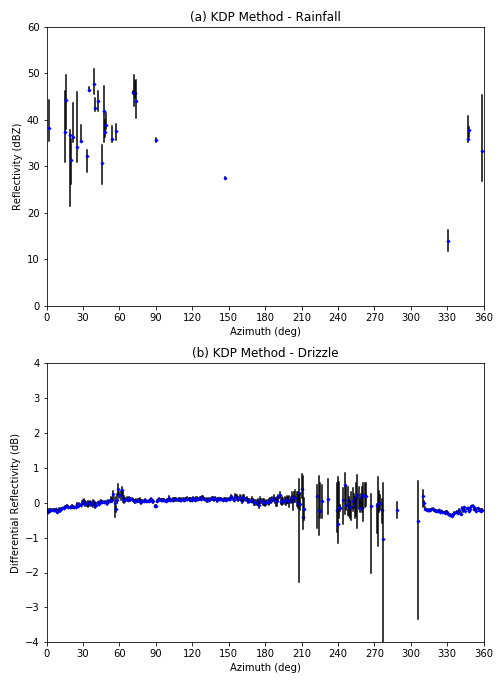

In [24]:
from IPython.core.display import Image 
Image(filename='/Volumes/Storage01/PyBlock/block_kdp_method.png')

So nowhere near enough data to get anything useful from the rain, but the drizzle statistics are starting to settle down in most azimuths. There are still some gaps, though. Generally you need hundreds of volumes to get robust statistics for the KDP method. This is normally easily achieved in most field campaigns, and for permanent radar installations it is virtually guaranteed. For the FSC method the requirements are lower because more data in each volume meet the relaxed criteria. 

OK, for now let's just pretend we got enough data. Now what? The basic rhythm of PyBlock is you first process all the radar volumes using BeamBlockMultiVolume, and then you analyze the resultant data using the KDP and FSC analysis objects, to be discussed in the next sections.

<hr>

### KDP Method Analysis

Key to finalizing the KDP method analysis is the KdpMethodAnalysis object. You feed it the path and name of the KDP method blockage statistics file, and the azimuth intervals you consider to be unblocked, and it will compute the suggested Zh and Zdr corrections.

How do you know what azimuths to look at? Currently there is no automated way in PyBlock for figuring out which azimuths are blocked and which are not. The user needs to look at the final KDP method azimuth plots and the statistics file to figure this out. Once you determine all the unblocked azimuth intervals, you put them into a list like so: 

In [25]:
azimuths = [(0, 54), (65, 86), (96, 188), (191, 277), (313, 339), (352, 360)]

In [26]:
# Now run the analysis!
image_dir = '/Volumes/Storage01/PyBlock/'
fname = image_dir + 'blockage_stats_kdp_method.txt'
kdp_analysis = pyblock.KdpMethodAnalysis(fname, azimuths=azimuths)

Well, that was quick and anti-climactic ... What just happened is the suggested_corrections were determined and assigned to their respective azimuths. The workhorse object for this is the Corrections class, which is invoked by KdpMethodAnalysis for both the Zh and the Zdr corrections. Let's look at the Corrections class.

In [27]:
help(pyblock.Corrections)

Help on class Corrections in module pyblock.pyblock:

class Corrections(builtins.object)
 |  Calculate the suggested reflectivity/ZDR corrections. There are currently
 |  three approaches, which will tend to agree in well-behaved data (i.e.,
 |  confidence intervals are narrow). In data with wide confidence intervals,
 |  some corrections may not end up being suggested due to lack of certainty.
 |  standard: Difference between median reflectivity/ZDR in blocked azimuth
 |            & median of unblocked azimuths is > 1 dBZ or 0.1 dB (default) &
 |            the difference is greater than half the 95% confidence interval
 |            at that azimuth.
 |  loose: standard conditions apply plus the difference between the high
 |          value in the 95% interval at the blocked azimuth and the median in
 |          unblocked azimuths is still greater than half the unblocked
 |          confidence interval.
 |  strict: Difference between median reflectivity/ZDR in blocked azimuth
 |     

The kdp_analysis object now has two Corrections objects, zh_adjustments and zdr_adjustments, as attributes. Note the dictionary, called suggested_corrections, which has three different keys corresponding to three different methodologies for determining the Zh and Zdr offsets. All three methodologies will agree in well-behaved datasets, so for now let's just concern ourselves with the standard methodology.

In [28]:
print('azimuth, suggested Zh corr, suggested Zdr corr')
for i, az in enumerate(kdp_analysis.zh_adjustments.suggested_corrections['azimuth']):
    print(az, '%0.2f' % kdp_analysis.zh_adjustments.suggested_corrections['standard'][i],
          '%0.2f' % kdp_analysis.zdr_adjustments.suggested_corrections['standard'][i])

azimuth, suggested Zh corr, suggested Zdr corr
54.0 -32768.00 0.00
55.0 0.00 -0.21
56.0 0.00 0.00
57.0 -32768.00 0.21
58.0 0.00 0.00
59.0 0.00 -0.37
60.0 0.00 -0.20
61.0 0.00 -0.19
62.0 0.00 -0.34
63.0 0.00 0.00
64.0 0.00 0.00
86.0 0.00 0.00
87.0 0.00 0.00
88.0 0.00 0.00
89.0 0.00 0.12
90.0 -32768.00 0.10
91.0 0.00 0.00
92.0 0.00 0.00
93.0 0.00 0.00
94.0 0.00 0.00
95.0 0.00 0.00
188.0 0.00 0.00
189.0 0.00 0.00
190.0 0.00 0.00
277.0 0.00 0.00
278.0 0.00 -32768.00
279.0 0.00 -32768.00
280.0 0.00 -32768.00
281.0 0.00 -32768.00
282.0 0.00 -32768.00
283.0 0.00 -32768.00
284.0 0.00 -32768.00
285.0 0.00 -32768.00
286.0 0.00 -32768.00
287.0 0.00 -32768.00
288.0 0.00 -32768.00
289.0 0.00 0.24
290.0 0.00 -32768.00
291.0 0.00 -32768.00
292.0 0.00 -32768.00
293.0 0.00 -32768.00
294.0 0.00 -32768.00
295.0 0.00 -32768.00
296.0 0.00 -32768.00
297.0 0.00 -32768.00
298.0 0.00 -32768.00
299.0 0.00 -32768.00
300.0 0.00 -32768.00
301.0 0.00 -32768.00
302.0 0.00 -32768.00
303.0 0.00 -32768.00
304.0 0.00 -3

You can also just use a method to print out this info, to screen as well as to file. This uses the pyblock.PrintBlock object. In this case, suggested corrections based on different methodologies will be displayed.

In [29]:
kdp_analysis.print_out_data()

Azimuth, ZH(std), ZH(strict), ZH(loose), Azimuth, DR(std), DR(strict), DR(loose)
--------------------------------------------------------
54.0,-32768.0,0.0,-32768.0,54.0,0.0,0.0,0.0
55.0,0.0,0.0,0.0,55.0,-0.214999995195,0.0,0.0
56.0,0.0,0.0,0.0,56.0,0.0,0.0,0.0
57.0,-32768.0,0.0,-32768.0,57.0,0.214999997057,0.214999997057,0.0
58.0,0.0,0.0,0.0,58.0,0.0,0.0,0.0
59.0,0.0,0.0,0.0,59.0,-0.374999991618,0.0,0.0
60.0,0.0,0.0,0.0,60.0,-0.200000002049,0.0,0.0
61.0,0.0,0.0,0.0,61.0,-0.194999999367,0.0,0.0
62.0,0.0,0.0,0.0,62.0,-0.335000014864,0.0,0.0
63.0,0.0,0.0,0.0,63.0,0.0,0.0,0.0
64.0,0.0,0.0,0.0,64.0,0.0,0.0,0.0
86.0,0.0,0.0,0.0,86.0,0.0,0.0,0.0
87.0,0.0,0.0,0.0,87.0,0.0,0.0,0.0
88.0,0.0,0.0,0.0,88.0,0.0,0.0,0.0
89.0,0.0,0.0,0.0,89.0,0.115000003018,0.115000003018,0.0
90.0,-32768.0,0.0,-32768.0,90.0,0.104999997653,0.104999997653,0.0
91.0,0.0,0.0,0.0,91.0,0.0,0.0,0.0
92.0,0.0,0.0,0.0,92.0,0.0,0.0,0.0
93.0,0.0,0.0,0.0,93.0,0.0,0.0,0.0
94.0,0.0,0.0,0.0,94.0,0.0,0.0,0.0
95.0,0.0,0.0,0.0,95.0,0.0,

If there are no data at an azimuth, the suggested_correction is always 0. If there are data, but the correction is too large (Zh +35 dBZ or Zdr +3.5 dB by default) or the confidence intervals are too big then the correction gets set to pyblock.BAD (-32768 by default). Otherwise, it is possible to have a non-zero correction suggested in either direction (+/-). Due to the lack of data above, we only get a few valid suggested corrections for Zdr and basically none for Zh.

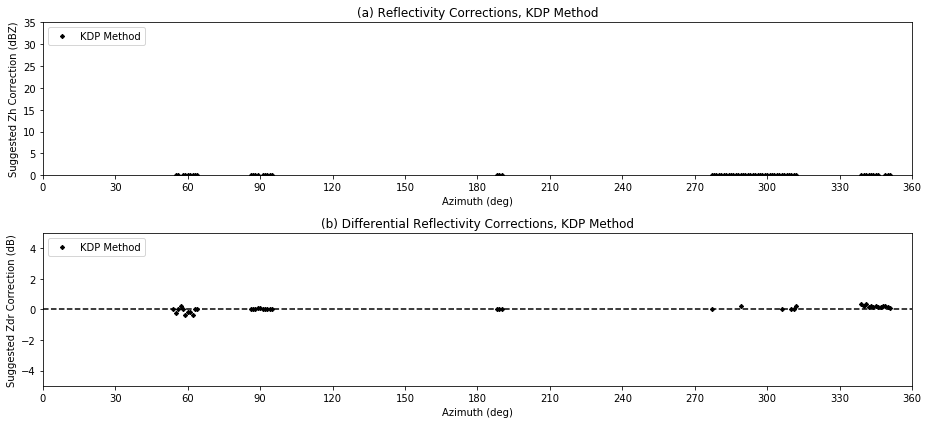

In [30]:
# You can also use a method to make a simple plot. This uses the pyblock._PlotBlock object.
kdp_analysis.plot_corrections()

###### It is strongly recommended that you do not blindly apply the respective suggested_correction to your Zh and Zdr data! 

Look hard at the behavior of the data at each azimuth, determine if there are enough data and whether there is a fixed offset in unblocked azimuths. For example, median Zdr in drizzle seemed to vary slowly but naturally with azimuth during IFloodS even in unblocked regions. In that case you need to account for the inherent "bias" at that azimuth. So PyBlock is a tool for estimating beam blockage but it should not be viewed as a black box.

In [31]:
# Get help on KdpMethodAnalysis
help(kdp_analysis)

Help on KdpMethodAnalysis in module pyblock.pyblock object:

class KdpMethodAnalysis(BlockStats, MaskHelper)
 |  Helper class that enables ingest and plotting of blockage statistics.
 |  
 |  Method resolution order:
 |      KdpMethodAnalysis
 |      BlockStats
 |      MaskHelper
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  __init__(self, filename, azimuths=[(0, 360)])
 |      azimuths = list of 2-element tuples defining blocked azimuths
 |  
 |  calc_blockage_correction(self)
 |  
 |  edit_corrections(self, azimuths, offsets, var='DZ', method='standard')
 |      azimuths = list of azimuths to adjust
 |      offsets = list of offsets to change to, same size and order as azimuths
 |      var = change to 'DR', 'ZDR', or 'ZD' to adjust ZDR rather than ZH
 |      method = 'standard', 'strict', or 'loose'
 |  
 |  get_unblocked_medians(self)
 |      Find median values and their confidence intervals in unblocked regions.
 |  
 |  isolate_blocked_data(self)
 |      Isolate 

OK, on to the final topic, using the FSC methodology.

<hr>

### FSC Method Analysis

In this case the relevant object is SelfConsistentAnalysis. It is a child of the proud parents RawDataStorage and MaskHelper. Wait, we saw MaskHelper in the last help statement, what is that?

In [32]:
help(pyblock.MaskHelper)

Help on class MaskHelper in module pyblock.pyblock:

class MaskHelper(builtins.object)
 |  Helper class to feed common methods for masking data to other classes
 |  
 |  Methods defined here:
 |  
 |  __init__(self)
 |      Initialize self.  See help(type(self)) for accurate signature.
 |  
 |  get_azimuth_mask(self, azimuths=[(0, 360)])
 |      azimuths = list of tuples, each containing a span of unblocked azimuths
 |                 to consider in the determination of the median Zh to compare
 |                 against blocked azimuths.
 |  
 |  ----------------------------------------------------------------------
 |  Data descriptors defined here:
 |  
 |  __dict__
 |      dictionary for instance variables (if defined)
 |  
 |  __weakref__
 |      list of weak references to the object (if defined)



Basically, it is a very stripped-down class that applies the blocked azimuth intervals you specified with the azimuths keyword to separate the blocked regions from the unblocked regions. Meanwhile, RawDataStorage gives SelfConsistentAnalysis access to the full gate-by-gate dataset (KdpMethodAnalysis only needed the statistics). It uses this dataset to determine a self-consistency relationship, and uses that relationship to compute and match integrals between the Kdp side of the equation and the Zh/Zdr side of the equation.  

In [44]:
fsc = pyblock.SelfConsistentAnalysis('./temporary_block_data.h5.gz', azimuths=azimuths)

That step, the instantiation of a SelfConsistentAnalysis object, basically preps the dataset by splitting up the blocked and unblocked data, and merging the unblocked azimuths together to allow a regression analysis for determining the self-consistency relationship. The next step is to actually perform the weighted multiple linear regression.

In [45]:
# zmin is the minimum Zh to look at in the regression, since Kdp is usually zero for low Zh.
fsc.regress_unblocked_medians(zmin=35)

/Users/tjlang/anaconda/envs/py3/lib/python3.6/site-packages/pyblock-1.4-py3.6.egg/pyblock/pyblock.py:1059: RuntimeWarning: invalid value encountered in log10
  self.logKdp = np.log10(self.unblocked_medians['KD'])


/Users/tjlang/anaconda/envs/py3/lib/python3.6/site-packages/pyblock-1.4-py3.6.egg/pyblock/pyblock.py:1093: RuntimeWarning: divide by zero encountered in log10
  [np.log10(self.unblocked_data['KD']), self.unblocked_data['DR']])
/Users/tjlang/anaconda/envs/py3/lib/python3.6/site-packages/pyblock-1.4-py3.6.egg/pyblock/pyblock.py:1093: RuntimeWarning: invalid value encountered in log10
  [np.log10(self.unblocked_data['KD']), self.unblocked_data['DR']])
/Users/tjlang/anaconda/envs/py3/lib/python3.6/site-packages/numpy/lib/function_base.py:968: RuntimeWarning: invalid value encountered in greater_equal
  not_smaller_than_edge = (sample[:, i] >= edges[i][-1])


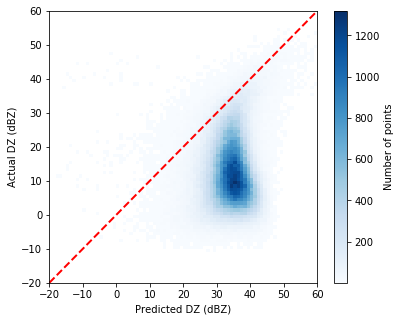

In [46]:
# Let's see how the regression did, by plotting predicted vs. actual Zh
fsc.plot_histogram_unblocked()

LOL, laughably bad. The lack of data (especially in moderate to heavy rain) is really hurting us here. For giggles, let's see what the a, b, and c coefficients in Zh = a + b * log10(Kdp) + c * Zdr actually turned out to be

In [47]:
print(fsc.a, fsc.b, fsc.c)

41.797274809 7.33393298637 5.21470693281


The regression analysis is a service that PyBlock provides, but you may have already determined the self-consistency relationship for your situation using disdrometer or some other data. Well, there's a method to replace the existing coefficients.

In [37]:
# Disdrometer-measured self-consistency for IFloodS
a = 44.12210083 
b = 10.34786
c = 2.66654
fsc.define_coefficients(a, b, c)

OK, now let's match the I1 and I2 integrals and determine the Zh offset, using these updated coefficients.

In [38]:
fsc.compute_I1_and_I2()

Zh adjustments determined & stored as zh_adjustments
ZDR offsets stored as zdr_offsets attribute


The zh_adjustments attribute has what you want for Zh. The zdr_offsets attribute is an experimental attempt at estimating the Zdr offset by examining the Zh=0 intercept of the Zdr(Zh) function at a specific blocked azimuth versus the same intercept in unblocked data. That methodology is unverified, although for now it is used to adjust Zdr in blocked azimuths for the purposes of matching the intergrals. Past literature has just used the KDP method to determine Zdr adjustments. I am working on incorporating the ability for the user to easily specify the Zdr offset per blocked azimuth manually. 

In [39]:
for index in fsc.blocked_azimuth_indices:
    key = str(index)
    print(key, fsc.I1[key], fsc.I2[key], fsc.zh_adjustments[key])

54 3.89416640904 5.16919688174 0.0
55 -2.9701773985 1.80973762514 0.0
56 48.4220986608 47.8892347997 10.2
57 44.1755483772 43.7845615746 6.1
58 5.43379271368 19.8232020524 0.0
59 7.02760844206 7.17139223116 0.0
60 27.0810976187 27.0363332578 5.0
61 24.60211147 24.8505302458 1.1
62 20.1366005915 20.1328774332 7.0
63 29.3192520598 29.6177847732 5.6
64 31.0819059517 30.961670511 6.6
86 -22.1991701744 20.0600069744 0.0
87 3.30126932997 19.7552900158 0.0
88 73.6779670839 74.456084543 11.1
89 120.908725409 120.173867724 7.7
90 11.0576236623 11.0020112902 3.2
91 36.137907202 36.4680580436 5.8
92 -3.9215694447 8.03037862895 0.0
93 23.8713084384 23.8306196839 3.4
94 0.84439017612 10.009161821 0.0
95 40.1220529539 39.9687751567 7.4
188 5.43636415829 5.48391282361 9.2
189 17.7178839173 17.5797261853 14.1
190 -28.4711612638 0.303570705224 0.0
277 2.91779571399 2.57410453019 34.9
278 0.0 0.0 0.0
279 0.0 0.0 0.0
280 0.0 0.0 0.0
281 0.0 0.0 0.0
282 0.0 0.0 0.0
283 0.0 0.0 0.0
284 0.0 0.0 0.0
285 0.0 

In [40]:
#Or just use a method to simplify the printout process and get a text file
fsc.print_out_data()

Azimuth, I1, I2, ZH(fsc), DR(fsc)
--------------------------------------------------------
54.0,3.89416640904,5.16919688174,0.0,0.219999998808
55.0,-2.9701773985,1.80973762514,0.0,0.330000013113
56.0,48.4220986608,47.8892347997,10.2,-0.34999999404
57.0,44.1755483772,43.7845615746,6.1,-0.34999999404
58.0,5.43379271368,19.8232020524,0.0,-0.34999999404
59.0,7.02760844206,7.17139223116,0.0,-0.34999999404
60.0,27.0810976187,27.0363332578,5.0,-0.34999999404
61.0,24.60211147,24.8505302458,1.1,-0.34999999404
62.0,20.1366005915,20.1328774332,7.0,0.355000019073
63.0,29.3192520598,29.6177847732,5.6,-0.769999980927
64.0,31.0819059517,30.961670511,6.6,0.664999991655
86.0,-22.1991701744,20.0600069744,0.0,0.330000013113
87.0,3.30126932997,19.7552900158,0.0,0.0700000077486
88.0,73.6779670839,74.456084543,11.1,0.239999979734
89.0,120.908725409,120.173867724,7.7,-0.209999993443
90.0,11.0576236623,11.0020112902,3.2,0.440000027418
91.0,36.137907202,36.4680580436,5.8,0.140000000596
92.0,-3.9215694447,8.030

If you remember Giangrande and Ryzhkov (2005), then you know these I1 and I2 values are way too low to trust the results. But at least you see how to access the results of these analyses. Once again, don't just blindly start applying these corrections even if you have millions of points. Check against the KDP method, check your regressions, verify, verify, verify!

Check the help for SelfConsistentAnalysis and in particular pay attention to how the azimuths are treated. Recall that you can use azimuth bins that are wider or narrower than 1.0 deg, so special consideration needs to be made for these cases.

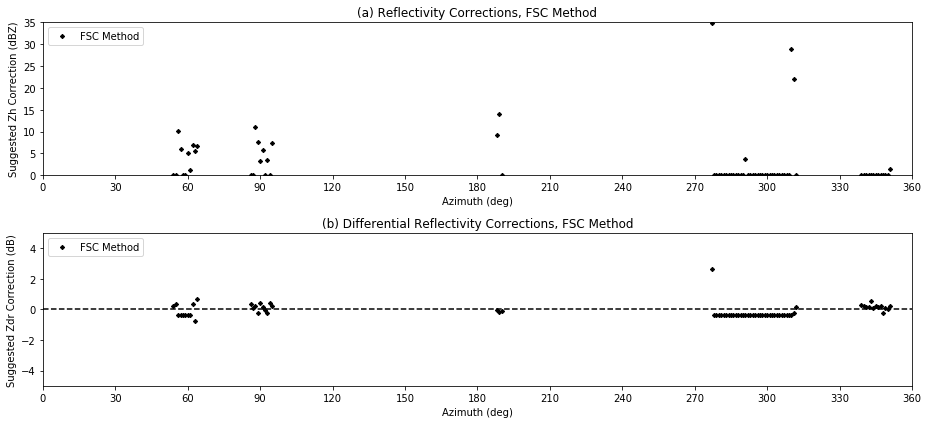

In [41]:
# Can plot results too.
fsc.plot_corrections()

In [42]:
help(fsc)

Help on SelfConsistentAnalysis in module pyblock.pyblock object:

class SelfConsistentAnalysis(MaskHelper)
 |  Class to facilitate the diagnosis of partial beam blockage via the fully
 |  self-consistent (FSC) method as applied in Lang et al. (2009). The anchor
 |  reference for this technique is Giangrande and Ryzhkov (2005).
 |  
 |  Since this can be confusing, let's explain how we treat the data.
 |  
 |  *self.Azimuth, self.blocked_azimuths, and self.unblocked_azimuths are float
 |   arrays that give the actual azimuth associated with each bin.
 |  *self.azimuth_indices and its blocked and unblocked variants are integer
 |   arrays that provide the relevant bin number for each azimuth. This
 |   distinction with the above allows the user to set wider or narrower bins
 |   than 1 deg. Then string conversions of these indices are the dictionary
 |   keys for the zh_adjustments and other associated attributes.
 |  
 |  A simple code snippet to get the zh_adjustments in a more typical

<hr>

###### Parting advice: PyBlock is not a black box!